In [1]:
!pip install -U tf_keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.3 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 672.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 78.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.1
    Uninstalling tensorflow-2.18.1:
      Successfully uninstalled tensorflow-2.18.1
  Attempting uninstall: tf_keras
    Found existing installation: tf_keras 2.18.0
    Uninstalling tf_keras-2.18.0:
      Successfully uninst

In [2]:
!pip install ktrain==0.41.4 tensorflow==2.15.0 tf_keras==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 42.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 832.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 47.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.4 MB/s eta 0:00

In [3]:
# Importing necessary packages
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

try:
  import ktrain
except:
  !pip install ktrain
  #os.kill(os.getpid(), 9)
    
import ktrain
import pandas as pd
import numpy as np
import requests

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [4]:
# Loading from ktrain
from ktrain import text
from ktrain.text import texts_from_df

In [5]:
print(ktrain.__version__)

0.41.4


In [6]:
# Load data
data = pd.read_csv('/kaggle/input/news-category-training-data-csv/news_category_trainingdata.csv')
print("Data loaded. Shape:", data.shape)
print("Data Info:", data.info)

Data loaded. Shape: (200853, 6)
Data Info: <bound method DataFrame.info of              category                                           headline  \
0               CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1       ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2       ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3       ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4       ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   
...               ...                                                ...   
200848           TECH  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   
200849         SPORTS  Maria Sharapova Stunned By Victoria Azarenka I...   
200850         SPORTS  Giants Over Patriots, Jets Over Colts Among  M...   
200851         SPORTS  Aldon Smith Arrested: 49ers Linebacker Busted ...   
200852         SPORTS  Dwight Howard Rips Teammates After Magic Loss ...   

            

In [7]:
# Feature engineering
data['feature'] = data['headline'] + ' ' + data['short_description']
print("Features created. First few rows:")
print(data[['feature', 'category']].head())

Features created. First few rows:
                                             feature       category
0  There Were 2 Mass Shootings In Texas Last Week...          CRIME
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT
2  Hugh Grant Marries For The First Time At Age 5...  ENTERTAINMENT
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT


In [8]:
# Creating Variables
data['health'] = np.where((data['category'] == 'WELLNESS') | (data['category'] == 'HEALTHY LIVING'), 1, 0)
print("Health label stats:\n", data['health'].describe())

Health label stats:
 count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: health, dtype: float64


In [9]:
# Balancing
sample_amt = int(data['health'].sum())
print("Sample size:", sample_amt)
wellness = data[data['health'] == 1]
not_wellness = data[data['health'] == 0].sample(n=sample_amt, random_state=42)
data_sample = pd.concat([wellness, not_wellness])
print("Balanced dataset stats:\n", data_sample.describe())

Sample size: 24521
Balanced dataset stats:
              health
count  49042.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


In [10]:
# Preprocess with ktrain
target_names = ['NOT HEALTH', 'HEALTH']
train, val, preprocess = text.texts_from_df(
    data_sample,
    text_column='feature',
    label_columns=['health'],
    val_df=None,
    max_features=20000,
    maxlen=128,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode='distilbert',
    verbose=1
)
print("Data preprocessed successfully")

['not_health', 'health']
        not_health  health
192960         0.0     1.0
175454         1.0     0.0
21974          0.0     1.0
100456         1.0     0.0
169620         0.0     1.0
['not_health', 'health']
        not_health  health
98556          0.0     1.0
147299         1.0     0.0
149342         0.0     1.0
24535          0.0     1.0
19328          1.0     0.0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 58
	99percentile : 67


Data preprocessed successfully


In [11]:
# Define the model
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=32)

Finding optimal learning rate...
simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1379/1379 [==============================] - 2474s 2s/step - loss: 0.4765 - accuracy: 0.7461
Epoch 2/2
1379/1379 [==============================] - 1010s 732ms/step - loss: 14.9076 - accuracy: 0.4940


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


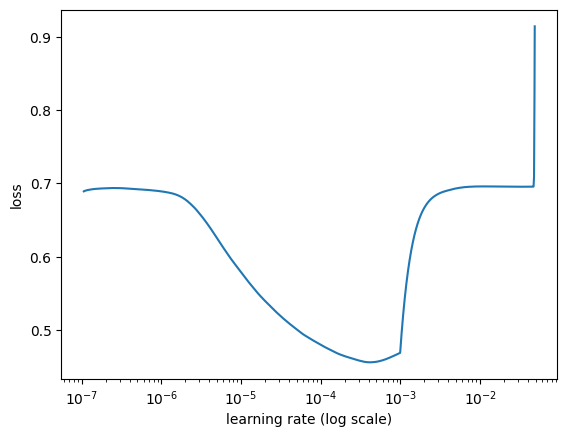

In [12]:
# Optional: Find optimal learning rate
print("Finding optimal learning rate...")
learner.lr_find(max_epochs=2)
learner.lr_plot()

In [13]:
# Train the model
learner.autofit(
    lr=1e-4,
    checkpoint_folder='/checkpoint',
    epochs=1,  # Reduced for faster testing
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
1380/1380 [==============================] - 2476s 2s/step - loss: 0.2788 - accuracy: 0.8813 - val_loss: 0.2258 - val_accuracy: 0.9009
Weights from best epoch have been loaded into model.


In [14]:
# Save predictor
predictor = ktrain.get_predictor(learner.model, preprocess)
predictor.save('wellness_predictor')
print("Model saved to /content/drive/MyDrive/wellness_predictor")

Model saved to /content/drive/MyDrive/wellness_predictor


In [15]:
# Validate model
validation = learner.validate(val_data=val, class_names=target_names)
print("Validation metrics:\n", validation)

154/154 [==============================] - 83s 511ms/step
              precision    recall  f1-score   support

  NOT HEALTH       0.90      0.90      0.90      2483
      HEALTH       0.90      0.90      0.90      2422

    accuracy                           0.90      4905
   macro avg       0.90      0.90      0.90      4905
weighted avg       0.90      0.90      0.90      4905

Validation metrics:
 [[2245  238]
 [ 248 2174]]


In [16]:
# Test predictions
test_docs = [
    'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
    'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
    'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
    'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
    'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
    'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
]

for i, text in enumerate(test_docs):
    probs = predictor.predict(text, return_proba=True)
    print("---------------------------")
    print(f'The probability this is healthy is {probs[1]:.4f}')
    print(text)

---------------------------
The probability this is healthy is 0.9939
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.9404
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.9216
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.9558
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.0041
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney d